# Kepler model
Algorithm starting from trajectories, trying to overcome the issue of sampling

Also, we could take a batch of initial conditions and then see if it generalizes to others... is there a
critical value of the batch to have good generalization?

## Settings

In [1]:
import numpy as np
#from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf

import sys
sys.path.append("../")
from models import *
from hamiltonians import kepler
from utils import make_train_op
from losses import make_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic

import os

DTYPE=tf.float32
NP_DTYPE=np.float32


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
sess = tf.InteractiveSession()

In [3]:
tf.set_random_seed(0)

In [4]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [5]:
k = -1
settings = {
    'k': k,
    'hamiltonian': lambda x : kepler(x,k=k),
    'd': 3,                    # space dimension
    'num_particles': 1,        # number of particles
    'minibatch_size': 2**7,    # Mini batch size
    'num_time_samples': 2**10, # Set to float("inf") for keeping sampling.
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/kepler",
    'visualize': True,
    #
#    'train_iters': 1000,
    'starter_learning_rate': 1e-3, # for exp decay and none
    'decay_lr': "piecewise",
#     'decay_steps': 15000,  # for exp decay
#     'decay_rate': 0.5,     # for exp decay
    'boundaries': [20000, 200000], # for piecewise decay
    'values': [1e-3, 1e-4, 1e-5],  # for piecewise decay
    'min_learning_rate': 1e-5, 
    #
    'loss': "circle",
#    'base_dist': "action_exponential_angle",
#    'base_dist': "action_dirac_angle"
#    'diff_val': -.5, 
#    'lambda_diff': 1.   # coeff |K-val|^2
#     ,
#     'elastic_net_coeff': 0., 
#     'low_K_range': -100, # A large value means all above this are OK
#     'high_K_range': -.01, 
#     'lambda_range': 10000.    # coeff range penalty
    }
# Choose a batch of actions: needs to be divisor of dataset_size or minibatch_size if infinite dataset
# r = np.random.RandomState(seed=0)
# num_samples_actions = 1 # number of distinct actions (Liouville torii)
# sh = (num_samples_actions, settings['d'], settings['num_particles'], 1)
# settings['value_actions'] = r.rand(*sh).astype(NP_DTYPE)
# print(settings['value_actions'])

## Eqs of motion

Get data by sampling trajectories

In [6]:
# sh = (settings['d'], settings['num_particles'], 2)
# flattened_sh = (settings['d']*settings['num_particles']*2,)
# from models import hamiltonian_vector_field
# def f(t, x): 
#     # x is a flattened vector. t is unused in ham_vec_field
#     # TODO: compute ham vec field by hand. This uses tf... 
#     return hamiltonian_vector_field(settings['hamiltonian'], np.reshape(x, sh), t)
# traj = solve_ivp(f, [0, 10], np.reshape(x0, flattened_sh))

In [7]:
# Initial conditions
# r = np.random.RandomState(seed=0)
# num_samples_actions = 1 # number of distinct initial conditions determining constants of the motion 
# x0 = r.rand(num_samples_actions, settings['d'], settings['num_particles'], 2).astype(NP_DTYPE)

def make_initial_x(eccentricity=np.array(0.6)):
    batch = eccentricity.shape[0]
    q1 = np.expand_dims(1 - eccentricity,1)
    p2 = np.expand_dims(np.sqrt((1+eccentricity) / (1-eccentricity)),1)
    q2 = q3 = p1 = p3 = np.zeros((batch,1))
    x = np.reshape(np.concatenate((q1, p1, q2, p2, q3, p3),axis=1), [batch,3,1,2])
    return x
#    x0 = np.reshape([1-eccentricity, 0., 0, np.sqrt((1+eccentricity) / (1-eccentricity)), 0, 0], [1,3,1,2])
    
eccentricity = np.array([.9])
assert settings['d']==3 and settings['num_particles']==1
x0 = make_initial_x(eccentricity)
q0,p0 = extract_q_p(x0)
print("q0 = ", np.reshape(q0,[-1]))
print("p0 = ", np.reshape(p0,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](x0) ))

q0 =  [0.1 0.  0. ]
p0 =  [0.         4.35889894 0.        ]
E  =  -0.4950037468777335


In [8]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=settings['num_time_samples'])
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj.shape)
qtraj, ptraj = extract_q_p( traj )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(1024, 1, 3, 1, 2)


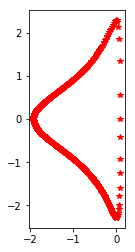

In [9]:
# orbits
dd = 0; nn = 0; bb = 0;
plt.plot(qtraj[:,bb,dd,nn,0], ptraj[:,bb,dd,nn,0],'r*')
#plt.plot(qtraj[:,bb,0,nn,0], qtraj[:,bb,1,nn,0],'b+')
plt.gca().set_aspect('equal', adjustable='box')

In [10]:
# qtraj[:,dd,nn,0] # all zeros since because of the initial conditions, in the xy plane only

In [13]:
from utils import join_q_p

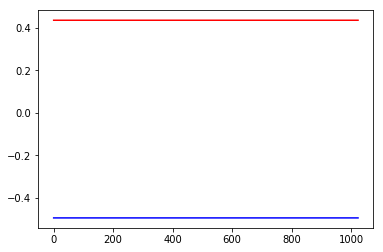

In [15]:
# conserved quantities: angular momentum and energy
J3 = np.multiply(qtraj[:,0,0,0], ptraj[:,1,0,0]) - np.multiply(qtraj[:,1,0,0], ptraj[:,0,0,0])
E = sess.run( settings['hamiltonian']( join_q_p(qtraj,ptraj) ) )
ts = np.arange(0.,10.,.01)
plt.plot(J3,'r')
plt.plot(E,'b')

## Define the model and loss

Define the model as sequence of a symplectic transformation T 

In [11]:
# No oscillator flow, map directly to phat,qhat cartesian coords of action-angle
stack = []
for i in range(settings['num_stacks_bijectors']):
    stack.extend([ #ZeroCenter(is_training_forward=False),
                  LinearSymplectic(),
#                  SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh))])
                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())])
T = Chain(stack)

The loss imposes that the trajectories in the transformed coordinates $\hat{q},\hat{p}$ are on circles of radius given by the actions. We choose the following one which makes couples of points have the same radius:
$$
\ell = \sum_d \sum_n \sum_{i=0}^{N-1} 
\left[\hat{q}(i,d,n)^2+\hat{p}(i,d,n)^2 - (\hat{q}(i-1,d,n)^2+\hat{p}(i-1,d,n)^2)\right]^2
$$

In general, we have a batch of trajectories and we want to impose that transformed coordinates for each batch are on the circle.

In [12]:
def make_circle_loss(z, shift=-1):
    """Here z is (time, batch, d, n, 2)"""
    zsq = tf.square(z)
    qhatsq, phatsq = extract_q_p(zsq)    
    diff_qhatsq = qhatsq - tf.roll(qhatsq, shift=shift, axis=0)
    diff_phatsq = phatsq - tf.roll(phatsq, shift=shift, axis=0)
    # TODO: sqrt?
#    return tf.reduce_mean(tf.square(diff_qhatsq + diff_phatsq))
    return tf.reduce_sum(tf.square(diff_qhatsq + diff_phatsq))

In [13]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

# traj is (num_time_samples,batch,d,n,2)
dataset = tf.data.Dataset.from_tensor_slices(traj.astype(NP_DTYPE))
# repeat the dataset indefinetely
dataset = dataset.repeat()
# Shuffle data every epoch time (0th) dimension
dataset = dataset.shuffle(settings['num_time_samples'])
# Specify the minibatch size
dataset = dataset.batch(settings['minibatch_size'])
data_iterator = dataset.make_one_shot_iterator()
x = data_iterator.get_next()

loss = make_loss(settings, T, x)

train_op = make_train_op(settings, loss, step)

## Train

In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
losses = []
# Coordinates to monitor
dd = 0; nn = 0
loss_np = 1 # Init
loss_converged = 5e-7

Loss at 25000 is 0.09025143086910248


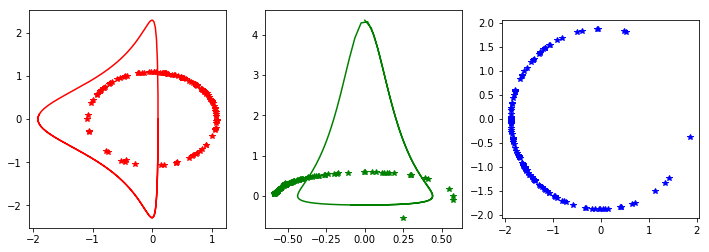

KeyboardInterrupt: 

In [16]:
while loss_np > loss_converged:
    _, it, loss_np = sess.run([train_op, step, loss])
    if it % 200 == 0:        
        display.clear_output(wait=True)
        print("Loss at {} is {}".format(it, loss_np))
        fig = plt.figure(figsize=(12,4))
        qhat_traj,phat_traj = sess.run(extract_q_p(z))

        cols=['r','g','b']        
        b = 0 # batch
        for n in range(settings['d']):
            plt.subplot(1, settings['d'], n + 1)
            plt.plot(qtraj[:,b,n,0,0], ptraj[:,b,n,0,0], cols[n]+'-')
            plt.plot(qhat_traj[:,b,n,0,0], phat_traj[:,b,n,0,0], cols[n]+'*')
        
        plt.gca().set_aspect('equal', adjustable='box')
        #plt.savefig('../results/kepler/image_at_it_{:04d}.png'.format(it))
        plt.show()   
    losses.append(loss_np)    

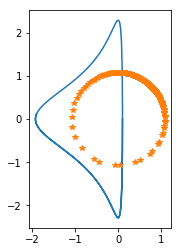

In [26]:
n = 0
plt.plot(qtraj[:,n,0,0], ptraj[:,n,0,0], '-')
plt.plot(qhat_traj[:,n,0,0], phat_traj[:,n,0,0], '*')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('../results/kepler_t2c.png')

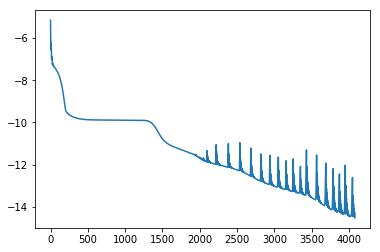

In [16]:
plt.plot(np.log(losses[:]))

In [19]:
!pip install -q imageio

In [20]:
import glob
import imageio
path='../results/kepler/'
with imageio.get_writer(path+'kepler.gif', mode='I') as writer:
    filenames = glob.glob(path+'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename(path+'kepler.gif', 'kepler.gif.png')

In [15]:
#display.Image(filename="kepler.gif.png")